In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../data/raw.csv")
df.head() 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df["readmit_30"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)
df["readmit_30"].value_counts()

readmit_30
0    90409
1    11357
Name: count, dtype: int64

In [4]:
df.isna().sum().sort_values(ascending=False)

max_glu_serum               96420
A1Cresult                   84748
encounter_id                    0
chlorpropamide                  0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
examide                         0
citoglipton                     0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
readmitted                      0
glimepiride                     0
repaglinide                     0
nateglinide                     0
patient_nbr                     0
race          

In [5]:
# Handle missing values and separete features
# categorical = df.select_dtypes(include=["object"]).columns.drop("readmitted")
categorical = df.select_dtypes(include=["object"]).columns
categorical = categorical.drop("readmit_30", errors="ignore")  # safe even if it doesn’t exist

numerical = df.select_dtypes(exclude=["object"]).columns

print("Categorical: ", categorical)
print("Numerical: ", numerical)

Categorical:  Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
Numerical:  Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'readmit_30'],
      dtype='object')

In [6]:
# Handle missing values
df = df.drop(columns=["encounter_id", "patient_nbr"])

In [7]:
# Replace "?" with NaN and forward fill
df.replace("?", pd.NA, inplace=True)
df.fillna(method="ffill", inplace=True)

/var/folders/2g/fnln3gmx15z1g9xv8r0swrhm0000gn/T/ipykernel_7865/4029715985.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [8]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical, drop_first=True)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Separate target FIRST
y = df["readmit_30"]
X = df.drop("readmit_30", axis=1)

# 2. Select numerical columns from FEATURES ONLY
numerical = X.select_dtypes(exclude="object").columns

# 3. Scale ONLY feature columns
scaler = StandardScaler()
X[numerical] = scaler.fit_transform(X[numerical])

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [11]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # probability of class 1

In [12]:
# Evaluate performance
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9994595656873342
ROC-AUC: 0.9999996834402197
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18083
           1       1.00      1.00      1.00      2271

    accuracy                           1.00     20354
   macro avg       1.00      1.00      1.00     20354
weighted avg       1.00      1.00      1.00     20354

Confusion Matrix:
 [[18072    11]
 [    0  2271]]


In [13]:
# Interpret model coefficients
import pandas as pd

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df.head(20)  # top positive predictors
coef_df.tail(20)  # top negative predictors


,feature,coefficient
580,diag_1_656,-0.044863
2028,diag_3_659,-0.046151
2011,diag_3_626,-0.047573
583,diag_1_659,-0.047719
192,diag_1_218,-0.048627
1254,diag_2_626,-0.048895
588,diag_1_664,-0.049524
586,diag_1_661,-0.050668
2032,diag_3_663,-0.052833
2033,diag_3_664,-0.056332


In [14]:
# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=200,  # number of trees
    random_state=42,
    n_jobs=-1  # use all CPU cores
)

# Train on the training set
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [15]:
#Make predictions
y_rf_pred = rf.predict(X_test)           # predicted labels: 0 or 1
y_rf_prob = rf.predict_proba(X_test)[:,1]  # predicted probability of readmission

In [16]:
#Evaluate performance
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

print("=== Random Forest Performance ===")
print("Accuracy:", accuracy_score(y_test, y_rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_rf_prob))
print(classification_report(y_test, y_rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_rf_pred))

=== Random Forest Performance ===
Accuracy: 0.9954800039304313
ROC-AUC: 0.9999999999999999
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18083
           1       1.00      0.96      0.98      2271

    accuracy                           1.00     20354
   macro avg       1.00      0.98      0.99     20354
weighted avg       1.00      1.00      1.00     20354

Confusion Matrix:
 [[18083     0]
 [   92  2179]]


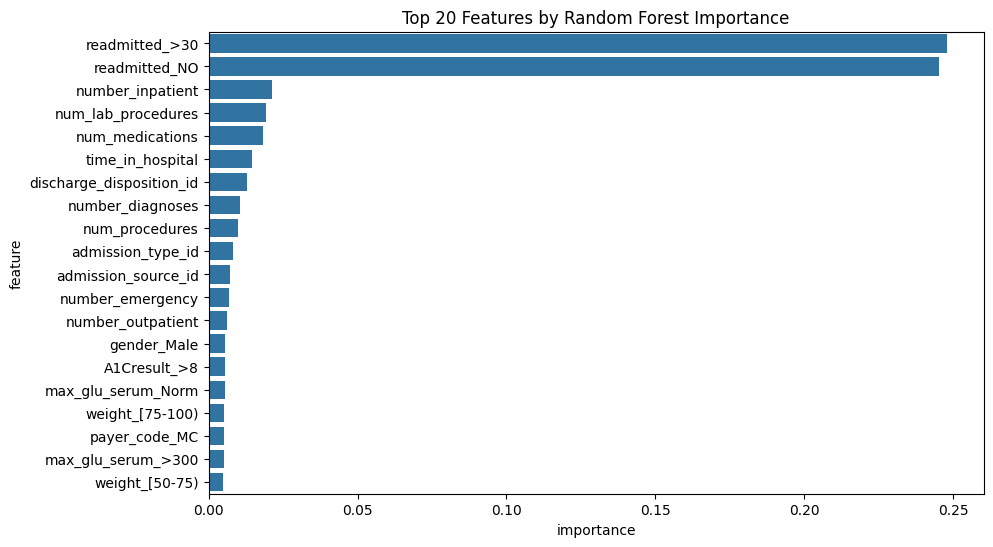

In [17]:
# Feature Importance Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from Random Forest
rf_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=rf_importances.head(20))
plt.title("Top 20 Features by Random Forest Importance")
plt.show()


In [18]:
# Save the trained model and scaler
import joblib

joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")

['feature_columns.pkl']